这个版本添加了 促销频率特征、两种不同渠道的SKU预测测试

In [8]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn
from scipy import stats
from scipy.stats import pearsonr
import re
import math
import time
import datetime
from matplotlib.backends.backend_pdf import PdfPages
import warnings 
warnings.filterwarnings("ignore") 
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns', None)

In [9]:
order_m = pd.read_csv("order_modified_20190618.csv")
order_m["paytime_day"] = order_m["paytime"].astype(str).apply(lambda x: x[:10])
order_m = order_m[["order_bn", "qty", "default_stock_id", "sku_id", "paytime_day"]]

order = pd.read_csv("order_20190618.csv")
order["paytime_day"] = order["paytime"].astype(str).apply(lambda x: x[:10])
order = order[order["stock_name_cn"].str.contains("花桥")]

order = pd.merge(order, order_m, how="right", on=["sku_id", "order_bn", "paytime_day", "qty"])
order = order[order["default_stock_id"] == 1]
order = order[["sku_id", "tmall_id", "logi_name", "ship_province", "qty", "sales_amount", "paytime_day"]]
order.head(5)

,sku_id,tmall_id,logi_name,ship_province,qty,sales_amount,paytime_day
0,534154,4.383156e+10,圆通速递,上海,1,19.90,2015-12-22
1,534154,4.383156e+10,圆通速递,上海,1,19.37,2016-01-06
2,534154,4.383156e+10,圆通速递,安徽,1,19.90,2016-01-18
3,534154,4.383156e+10,圆通速递,浙江,1,19.90,2016-01-22
4,534154,4.383156e+10,圆通速递,江苏,5,99.50,2016-01-27


In [7]:
order_copy = pd.DataFrame()
for sku in list(set(order['sku_id'])):
    skudata = order[order['sku_id']==sku].reset_index(drop=True)
    date_index = pd.DataFrame(pd.date_range(min(skudata['paytime_day']), max(skudata['paytime_day'])))
    date_index.columns = ['paytime_day']
    date_index['paytime_day'] = date_index['paytime_day'].apply(lambda x: str(x)[:10])
    skudata = date_index.merge(skudata, on='paytime_day',how='left')#.fillna(0)
    skudata['sku_id'] = sku
    #skudata['no_record'] = [1 if np.isnan(x) else 0 for x in skudata.iloc[:,-1]] #合并之后缺失X的标为1
    skudata = a = pd.concat([skudata.iloc[:,:5], skudata.iloc[:,5:].fillna(0)], axis=1)
    skudata['tmall_id'] = skudata['tmall_id'].astype(str)
    skudata['logi_name'] = skudata['logi_name'].astype(str)
    skudata['ship_province'] = skudata['ship_province'].astype(str)
    if order_copy.empty:
        order_copy = skudata.copy()
    else:
        order_copy = pd.concat([order_copy, skudata], axis=0)
order_copy.head(5)

,paytime_day,sku_id,tmall_id,logi_name,ship_province,qty,sales_amount
0,2019-04-19,2465803,nan,顺丰速运,上海,1.0,499.900
0,2019-03-28,2465804,551059204553.0,圆通速递,浙江,1.0,471.049
1,2019-03-29,2465804,nan,nan,nan,0.0,0.000
2,2019-03-30,2465804,nan,nan,nan,0.0,0.000
3,2019-03-31,2465804,nan,nan,nan,0.0,0.000


In [4]:
order_copy['target_qty'] = order_copy['qty']
target = order_copy[['sku_id','paytime_day', 'target_qty']]
target = target.groupby(['sku_id','paytime_day'], as_index=False).sum()

In [5]:
target.head(1)

,sku_id,paytime_day,target_qty
0,534154,2015-12-22,2.0


In [6]:
order = order_copy.copy()
order['paytime_day'] = order['paytime_day'].apply(
    lambda x: str(datetime.datetime.strptime(x[:10], "%Y-%m-%d") + datetime.timedelta(1))[:10])

# features: continue and discrete
conti_data = order[['sku_id', 'sales_amount', 'paytime_day']]#, 'qty', 'qty_tmall','qty_cube','promo_prefix' ]]
discrete_data = order[['tmall_id', 'logi_name', 'ship_province']].astype(str)
discrete_data = pd.get_dummies(discrete_data)
order = pd.concat([conti_data, discrete_data], axis=1)
order = order.groupby(['sku_id', 'paytime_day'], as_index=False).sum()

In [7]:
order.head(1)

,sku_id,paytime_day,sales_amount,tmall_id_0.0,tmall_id_37184487882.0,tmall_id_37203576456.0,tmall_id_38455358819.0,tmall_id_38781831288.0,tmall_id_40232632493.0,tmall_id_43584564331.0,tmall_id_43831555525.0,tmall_id_521523020325.0,tmall_id_521534993060.0,tmall_id_525561350368.0,tmall_id_526937281520.0,tmall_id_526987701843.0,tmall_id_546007403166.0,tmall_id_546739219743.0,tmall_id_547609682924.0,tmall_id_550423416156.0,tmall_id_551059204553.0,tmall_id_563058144583.0,tmall_id_567012365919.0,tmall_id_577940432188.0,tmall_id_587022674982.0,tmall_id_nan,logi_name_nan,logi_name_圆通速递,logi_name_大件物流,logi_name_宅急送,logi_name_德邦物流,logi_name_申通,logi_name_自有物流,logi_name_顺丰到付,logi_name_顺丰速运,ship_province_nan,ship_province_上海,ship_province_四川,ship_province_安徽,ship_province_新疆,ship_province_江苏,ship_province_江西,ship_province_河南,ship_province_浙江,ship_province_湖北,ship_province_福建,ship_province_西藏,ship_province_陕西
0,534154,2015-12-23,19.9,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0


In [8]:
# features: product
product_info_sub = pd.read_csv("product_info_sub_20190618.csv")
product_info_sub = product_info_sub[['sku_id', 'sports', 'code_e', 'ue']]
product_info = pd.read_csv("product_info_20190618.csv")
product_info = product_info[['sku_id', 'model_code', 'dsm_code','family_id', 'model_lifestage','item_lifestage', 
                             'item_range']]
product_info = product_info.merge(product_info_sub, on='sku_id', how='left')

In [9]:
product_info.head(1)

,sku_id,model_code,dsm_code,family_id,model_lifestage,item_lifestage,item_range,sports,code_e,ue
0,2491778,8488755,165457,11887,1,1,3,ROAD RUNNING,N,1


In [10]:
# features: promotion
promotion = pd.read_csv("promotion_20190618.csv")
promotion['promo_level_simple'] = promotion['promo_level'].astype(str).apply(
    lambda x: re.sub(u'[\u4e00-\u9fa5]+', 'Ch-others', x))
promotion['date'] = promotion['date'].apply(lambda x: datetime.datetime.strptime(x, "%Y/%m/%d"))
promotion['paytime_day'] = promotion['date'].apply(lambda x: str(x)[:10])
promotion = promotion[['promo_level_simple','paytime_day','promo_name']]

In [11]:
promotion.head(1)

,promo_level_simple,paytime_day,promo_name
0,nan,2016-01-02,NaN


In [12]:
# features: inventory_daily
inventory_daily = pd.read_csv("inventory_daily_20190618.csv")
inventory_daily['paytime_day'] = inventory_daily['account_time_bj_time'].apply(
    lambda x: str(datetime.datetime.strptime(x[:10], "%Y-%m-%d") + datetime.timedelta(1))[:10])
inventory_daily = inventory_daily[['sku_id', 'paytime_day','account_goods_stock']]
inventory_daily = inventory_daily.groupby(['sku_id', 'paytime_day'], as_index=False).sum()

In [13]:
inventory_daily.head(1)

,sku_id,paytime_day,account_goods_stock
0,534154,2017-01-02,11


In [14]:
# features: purchase_order
purchase_order = pd.read_csv("purchase_order_20190618.csv")
purchase_order['qty_purchase_order'] = purchase_order['qty']
purchase_order["paytime_day"] = purchase_order["create_on"].astype(str).apply(lambda x: x[:10])
purchase_order["paytime_day"] = pd.to_datetime(purchase_order["paytime_day"])
purchase_order["paytime_day"] = purchase_order["paytime_day"].astype(str)
purchase_order = purchase_order[['paytime_day', 'sku_id', 'qty_purchase_order', 'confirmed_qty', 'shipped_qty', 
                                 'cancel_qty']]
purchase_order = purchase_order.groupby(['paytime_day', 'sku_id'], as_index=False).sum()

In [15]:
purchase_order.head(1)

,paytime_day,sku_id,qty_purchase_order,confirmed_qty,shipped_qty,cancel_qty
0,2017-01-01,534154,5,5,5,0


In [16]:
# 合并所有X，都是按照target左连接，要保证连接之后target表的长度不变（即按照其他表的主键连接）
data = target.merge(inventory_daily, on=['sku_id','paytime_day'], how='left')
#data['miss_inventory_daily'] = [1 if np.isnan(x) else 0 for x in data.iloc[:,-1]] #缺失数据的标志
data = data.merge(purchase_order, on=['sku_id','paytime_day'], how='left')
#data['miss_purchase_order'] = [1 if np.isnan(x) else 0 for x in data.iloc[:,-1]]
data = data.merge(order, on=['sku_id','paytime_day'], how='left')
#data['miss_pre_order'] = [1 if np.isnan(x) else 0 for x in data.iloc[:,-1]]

data = data.merge(promotion, on='paytime_day', how='left')
data['promo_level_simple'] = data['promo_level_simple'].astype(str)
data = data.merge(product_info, on='sku_id', how='left')
data = data.fillna(0)
#data['promo_prefix'] = data['promo_prefix'].apply(lambda x: True if x>0 else False)

# 为非nan的促销活动打上标记，表示该天具有促销活动（构造促销频率特征）
data['promo_flag'] = data['promo_level_simple'].apply(lambda x: 1 if x != 'nan' else 0) 

In [17]:
# features: time series
def time_series_features(target_col, data, size = 14):
    '''
    target_col: 目标列，需要获取前几天的数据的列
    data: 目标数据集
    size: 向前追溯多少天，比如size=7即把target_col前1至前7天的数据作为特征
    除此之外，还加入 该SKU前七天的销量之和（target_col+'_1wb'） 和 与它同一个dsm code的SKU的前七天的销量之和
    （sales_amount_1wb_dsm）这两个特征 
    '''
    new_data = pd.DataFrame()
    data.index = list(range(len(data)))
    for sku in tqdm(list(set(data['sku_id']))):
        skudata = data[data['sku_id']==sku].reset_index(drop=True)
        for i in range(1, size+1):
            name = target_col + '_' + str(i) + 'db'
            skudata[name] = skudata[target_col].shift(i)  #1day before  一天前
        skudata[target_col+'_1wb'] = [np.nansum(skudata[target_col].iloc[i-7:i]) 
                                      if i >= 7 else sum(skudata[target_col].iloc[:i]) for i in skudata.index]
        
        code = data[data['sku_id']==sku]['dsm_code'].iloc[0]
        sales_amount_1wb_dsm = []
        for ti in skudata['paytime_day']:
            mindate = str(datetime.datetime.strptime(ti, "%Y-%m-%d") - datetime.timedelta(7))[:10]
            df = data[data['dsm_code']==code][data['paytime_day'] < ti][data['paytime_day'] > mindate]
            df = df[df['sku_id'] != sku]
            sales_amount_1wb_dsm.append(np.nansum(df[target_col]))
        skudata[target_col+'_1wb_dsm'] = sales_amount_1wb_dsm
        if new_data.empty:
            new_data = skudata.copy()
        else:
            new_data = pd.concat([new_data, skudata], axis=0)
    return new_data

def time_series_features_nodsm(target_col, data, size = 14):
    '''
    target_col: 目标列，需要获取前几天的数据的列
    data: 目标数据集
    size: 向前追溯多少天，比如size=7即把target_col前1至前7天的数据作为特征
    这里剔除了 dsm_code
    
    '''
    new_data = pd.DataFrame()
    data.index = list(range(len(data)))
    for sku in tqdm(list(set(data['sku_id']))):
        skudata = data[data['sku_id']==sku].reset_index(drop=True)
        for i in range(1, size+1):
            name = target_col + '_' + str(i) + 'db'
            skudata[name] = skudata[target_col].shift(i)  #1day before  一天前
            
        skudata[target_col+'_fnb'] = [np.nansum(skudata[target_col].iloc[i-14:i]) 
                                      if i >= 14 else sum(skudata[target_col].iloc[:i]) for i in skudata.index]
        # skudata['front_promo_flag'] = [1 if ((skudata['promo_flag'].iloc[i]==1) & 
        #                                (skudata[target_col+'_fnb'].iloc[i]==0)) else 0 for i in skudata.index]
        # front_promo_flag 将十四天前没有促销但当日是促销日的日期记0 这个特征太强，容易对所有这种促销进行“强调”，
        # 导致部分拟合好部分过度高估峰值
        
        if new_data.empty:
            new_data = skudata.copy()
        else:
            new_data = pd.concat([new_data, skudata], axis=0)
    return new_data

# 把前30天每一天的销量数据都作为特征加入
data = time_series_features('target_qty', data, size = 30)
# 把前14天每一天的sales_amount数据都作为特征加入
data = time_series_features('sales_amount', data, size = 14)

# 把前14天的促销频率作为特征加入
data = time_series_features_nodsm('promo_flag', data, size=14)
data = data.fillna(0)


#a = data[['target_qty_1db','target_qty']] 
discrete_data = data[['model_code', 'dsm_code','family_id', 'model_lifestage', 'item_lifestage', 'item_range',
'sports', 'code_e', 'ue']].astype(str)
discrete_data = pd.get_dummies(discrete_data)
data = data.drop(['model_code', 'dsm_code','family_id', 'model_lifestage', 'item_lifestage', 'item_range',
'sports', 'code_e', 'ue'],axis=1)
newdata=pd.concat([data, discrete_data],axis=1)

newdata = newdata.set_index([newdata['sku_id'], newdata['paytime_day']]).fillna(0)
newdata = newdata.drop(['promo_flag'], axis=1)

print('# sku in data: {}'.format(len(set(newdata['sku_id'].values))))

100%|██████████| 116/116 [00:04<00:00, 23.78it/s]


# sku in data: 116


In [18]:
# 尝试将促销效果进行一个衰减操作（越近时期的促销效果越好，衰减过程暂设定为指数衰减）
for i in range(0,14):
    newdata['promo_flag_{}db'.format(i+1)] = newdata['promo_flag_{}db'.format(i+1)].apply(
        lambda x: math.exp(-i*0.5) if x>0 else 0)

In [19]:
# features: promotion_modified
promo_dic = pd.read_csv("promotion_modified_20190620.csv")
promo_dic.columns=['name','sure','infer_from_name','infer_from_qty','problem']
promo_dic['sure']=promo_dic['sure'].astype(str)
promo_dic['sure']=promo_dic['sure'].apply(lambda x: x.split(','))
promo_dic['infer_from_name']=promo_dic['infer_from_name'].astype(str)
promo_dic['infer_from_name']=promo_dic['infer_from_name'].apply(lambda x: x.split(','))
promo_dic['infer_from_qty']=promo_dic['infer_from_qty'].astype(str)
promo_dic['infer_from_qty']=promo_dic['infer_from_qty'].apply(lambda x: x.split(','))
promo_dic['all']=promo_dic['sure']+promo_dic['infer_from_name']+promo_dic['infer_from_qty']
promo_dict={}
for i in range(len(promo_dic)):
    promo_dict[promo_dic['name'][i]]=promo_dic['all'][i]

newdata.index=np.arange(len(newdata))
newdata['is_promo']=[1 if newdata['promo_name'][i] in promo_dict.keys() and newdata['sku_id'][i]  in promo_dict[newdata['promo_name'][i]] else 0 for i in range(len(newdata))]
newdata['promo_level']=[newdata['promo_level_simple'][i] if newdata['is_promo'][i]==1 else 'no' for i in range(len(newdata))]

promo_level=pd.get_dummies(newdata['promo_level'])
newdata=pd.concat([newdata,promo_level],axis=1)
del newdata['promo_level']
del newdata['promo_level_simple']
del newdata['promo_name']

In [54]:
X_train = newdata[newdata['paytime_day'] < '2019-01-01']
y_train = newdata[newdata['paytime_day'] < '2019-01-01']['target_qty']
X_test = newdata[newdata['paytime_day'] >= '2019-01-01']
y_test = newdata[newdata['paytime_day'] >= '2019-01-01']['target_qty']

In [55]:
#X_train.columns.tolist()

### Training: quantile model

In [62]:
from sklearn.datasets import load_boston
from sklearn.linear_model import (LinearRegression, Ridge,
                                  Lasso, RandomizedLasso)
from sklearn.feature_selection import RFE, f_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from pandas import DataFrame
from sklearn.feature_selection import mutual_info_regression

np.random.seed(0)
Y = y_train
X = np.array(X_train.drop(['sku_id', 'paytime_day', 'target_qty'], axis=1))
X_t = np.array(X_test.drop(['sku_id', 'paytime_day', 'target_qty'], axis=1))
names = X_train.drop(['sku_id', 'paytime_day', 'target_qty'], axis=1).columns.tolist()
ranks = {}


def rank_to_dict(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order * np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x, 2), ranks)
    return dict(zip(names, ranks))


lr = LinearRegression(normalize=True)
lr.fit(X, Y)
ranks["Linear reg"] = rank_to_dict(np.abs(lr.coef_), names)
ridge = Ridge(alpha=7)
ridge.fit(X, Y)
ranks["Ridge"] = rank_to_dict(np.abs(ridge.coef_), names)
lasso = Lasso(alpha=.05)
lasso.fit(X, Y)
ranks["Lasso"] = rank_to_dict(np.abs(lasso.coef_), names)
rlasso = RandomizedLasso(alpha=0.04)
rlasso.fit(X, Y)
ranks["Stability"] = rank_to_dict(np.abs(rlasso.scores_), names)
#stop the search when 5 features are left (they will get equal scores)
rfe = RFE(lr, n_features_to_select=5)
rfe.fit(X, Y)


print('  ', list(map(float, rfe.ranking_)))

ranks["RFE"] = rank_to_dict(list(map(float, rfe.ranking_)), names, order=-1)
rf = RandomForestRegressor()
rf.fit(X, Y)
ranks["RF"] = rank_to_dict(rf.feature_importances_, names)
f, pval = f_regression(X, Y, center=True)
ranks["Corr."] = rank_to_dict(f, names)
mic_scores = mutual_info_regression(X, Y)
ranks["MIC"] = rank_to_dict(mic_scores, names)
r = {}
for name in names:
    r[name] = round(np.mean([ranks[method][name]
                             for method in ranks.keys()]), 2)
methods = sorted(ranks.keys())
ranks["Mean"] = r
methods.append("Mean")
#print("\t%s" % "\t".join(methods))

for name in names:
    print (name,'\t')
    for method in methods:
        print(method,'\t',ranks[method][name],'\t')
    print('\n')

/Users/xiujiayang/anaconda3/envs/python36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


   [129.0, 116.0, 118.0, 132.0, 117.0, 144.0, 65.0, 55.0, 68.0, 72.0, 61.0, 53.0, 52.0, 56.0, 66.0, 67.0, 57.0, 63.0, 69.0, 62.0, 51.0, 60.0, 50.0, 70.0, 49.0, 64.0, 71.0, 48.0, 59.0, 89.0, 30.0, 42.0, 46.0, 36.0, 39.0, 28.0, 45.0, 33.0, 58.0, 41.0, 29.0, 40.0, 47.0, 44.0, 34.0, 35.0, 38.0, 43.0, 31.0, 32.0, 37.0, 76.0, 77.0, 81.0, 79.0, 80.0, 82.0, 78.0, 138.0, 125.0, 146.0, 121.0, 133.0, 134.0, 126.0, 141.0, 130.0, 136.0, 123.0, 137.0, 135.0, 124.0, 119.0, 143.0, 140.0, 127.0, 139.0, 131.0, 120.0, 122.0, 128.0, 83.0, 142.0, 112.0, 115.0, 113.0, 110.0, 109.0, 114.0, 111.0, 145.0, 147.0, 148.0, 150.0, 149.0, 153.0, 151.0, 108.0, 154.0, 105.0, 100.0, 99.0, 104.0, 101.0, 102.0, 98.0, 97.0, 96.0, 95.0, 94.0, 93.0, 91.0, 92.0, 103.0, 26.0, 85.0, 75.0, 88.0, 73.0, 5.0, 2.0, 8.0, 24.0, 21.0, 90.0, 152.0, 25.0, 86.0, 166.0, 14.0, 162.0, 180.0, 177.0, 179.0, 178.0, 168.0, 173.0, 18.0, 175.0, 172.0, 165.0, 171.0, 170.0, 174.0, 1.0, 1.0, 54.0, 13.0, 20.0, 7.0, 6.0, 9.0, 169.0, 1.0, 19.0, 167.0, 

Corr. 	 0.01 	
Lasso 	 0.0 	
Linear reg 	 0.0 	
MIC 	 0.33 	
RF 	 0.02 	
RFE 	 0.22 	
Ridge 	 0.0 	
Stability 	 0.0 	
Mean 	 0.07 	


sales_amount_1db 	
Corr. 	 0.06 	
Lasso 	 0.0 	
Linear reg 	 0.0 	
MIC 	 0.55 	
RF 	 0.02 	
RFE 	 0.39 	
Ridge 	 0.0 	
Stability 	 0.0 	
Mean 	 0.13 	


sales_amount_2db 	
Corr. 	 0.06 	
Lasso 	 0.0 	
Linear reg 	 0.0 	
MIC 	 0.53 	
RF 	 0.02 	
RFE 	 0.37 	
Ridge 	 0.0 	
Stability 	 0.0 	
Mean 	 0.12 	


sales_amount_3db 	
Corr. 	 0.05 	
Lasso 	 0.0 	
Linear reg 	 0.0 	
MIC 	 0.53 	
RF 	 0.01 	
RFE 	 0.38 	
Ridge 	 0.0 	
Stability 	 0.0 	
Mean 	 0.12 	


sales_amount_4db 	
Corr. 	 0.05 	
Lasso 	 0.0 	
Linear reg 	 0.0 	
MIC 	 0.57 	
RF 	 0.06 	
RFE 	 0.4 	
Ridge 	 0.0 	
Stability 	 0.0 	
Mean 	 0.14 	


sales_amount_5db 	
Corr. 	 0.04 	
Lasso 	 0.0 	
Linear reg 	 0.0 	
MIC 	 0.56 	
RF 	 0.01 	
RFE 	 0.4 	
Ridge 	 0.0 	
Stability 	 0.0 	
Mean 	 0.13 	


sales_amount_6db 	
Corr. 	 0.05 	
Lasso 	 0.0 	
Linear reg 	 0.0 	
MIC 	 0.45 	
RF 	 0.03 	
RFE 	 0.38 

Corr. 	 0.01 	
Lasso 	 0.0 	
Linear reg 	 0.02 	
MIC 	 0.0 	
RF 	 0.0 	
RFE 	 0.91 	
Ridge 	 0.01 	
Stability 	 0.0 	
Mean 	 0.12 	


dsm_code_301240 	
Corr. 	 nan 	
Lasso 	 0.0 	
Linear reg 	 0.0 	
MIC 	 0.05 	
RF 	 0.0 	
RFE 	 0.1 	
Ridge 	 0.0 	
Stability 	 0.0 	
Mean 	 nan 	


dsm_code_301562 	
Corr. 	 nan 	
Lasso 	 0.0 	
Linear reg 	 0.0 	
MIC 	 0.0 	
RF 	 0.0 	
RFE 	 0.1 	
Ridge 	 0.0 	
Stability 	 0.0 	
Mean 	 nan 	


dsm_code_301703 	
Corr. 	 0.0 	
Lasso 	 0.0 	
Linear reg 	 0.01 	
MIC 	 0.01 	
RF 	 0.0 	
RFE 	 0.99 	
Ridge 	 0.0 	
Stability 	 0.0 	
Mean 	 0.13 	


dsm_code_302029 	
Corr. 	 nan 	
Lasso 	 0.0 	
Linear reg 	 0.0 	
MIC 	 0.0 	
RF 	 0.0 	
RFE 	 0.12 	
Ridge 	 0.0 	
Stability 	 0.0 	
Mean 	 nan 	


dsm_code_302557 	
Corr. 	 nan 	
Lasso 	 0.0 	
Linear reg 	 0.0 	
MIC 	 0.0 	
RF 	 0.0 	
RFE 	 0.15 	
Ridge 	 0.0 	
Stability 	 0.0 	
Mean 	 nan 	


dsm_code_305381 	
Corr. 	 nan 	
Lasso 	 0.0 	
Linear reg 	 0.0 	
MIC 	 0.0 	
RF 	 0.0 	
RFE 	 0.13 	
Ridge 	 0.0 	
Stability

In [67]:
sort_index = np.argsort(np.abs(rf.feature_importances_) )
print(sort_index)
import heapq
sorted_index=heapq.nlargest(150,range(len(sort_index)), sort_index.take)
print(sorted_index,len(sorted_index))
X = X[:,sorted_index]
X_t = X_t[:,sorted_index]

[185 171 170  49 165 164 163 162 161 160 156 155 152 143 142 141 140 139
 138 184 136 135 134 133 132 131 130 125  32 172 128  20 173  11  22  23
  24   9  27  12   7 127  36  16 149 119 150 124  15  21 115 183 137  26
 159 177 166 147   6 169 144 181 178   8 118 120 154 175 148  40 117 157
 121 123 116 146  31 180 129  42  18 151 168  33  50  35 145 126  17 122
 101  34  44  47 106 109  19 110 102 107 108 105 103  29  25 111  99  48
 176  14  45  39  38  41  80  37 153  90  63  60  70  54  53  51  64  87
  85  98  95  92 104  58  82 174  55  83 112  62  65  69  91  84  88  28
  71 158  77  56  73  66  67  61  75  10  93  52  96  79  68   5  97  72
  78  86  43 182   4  57 167  74 179 114 113  94  13  59 100  46  76  81
  89   3   1  30   2   0]
[0, 19, 51, 165, 61, 77, 170, 62, 55, 108, 67, 133, 32, 29, 1, 2, 59, 82, 168, 56, 4, 5, 6, 7, 8, 9, 54, 145, 71, 10, 11, 66, 116, 12, 81, 46, 44, 68, 57, 75, 86, 60, 13, 14, 15, 16, 17, 18, 52, 20, 21, 22, 23, 24, 25, 26, 78, 30, 41, 87, 27, 4

IndexError: index 165 is out of bounds for axis 1 with size 150

In [66]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel,RFECV,SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score

#selector = SelectKBest(lambda X, Y: np.array(map(lambda x:mic(x, Y), X.T)).T, k=100)
alpha = 0.98

param_test1 = {'n_estimators': range(50, 300, 25)}
gsearch1 = GridSearchCV(estimator = GradientBoostingRegressor(
                        n_estimators=250, 
                        loss='quantile',
                        alpha=alpha, 
                        random_state=0, 
                        max_depth=3, 
                        learning_rate=0.01),
                        param_grid=param_test1,
                        scoring='neg_mean_squared_error',
                        n_jobs=4,
                        iid=False,
                        cv=5)
gsearch1.fit(X, y_train)
print(gsearch1.best_params_, gsearch1.best_score_)

{'n_estimators': 275} -12.719925839521867


In [68]:
param_test2 = {
    'max_depth': range(2, 9, 2),
}
gsearch2 = GridSearchCV(estimator = GradientBoostingRegressor(
                        loss='quantile',
                        n_estimators=275, 
                        alpha=alpha, 
                        random_state=0, 
                        max_depth=8, 
                        learning_rate=0.01),
                        param_grid=param_test2,
                        scoring='neg_mean_squared_error',
                        n_jobs=4,
                        iid=False,
                        cv=5)
gsearch2.fit(X, y_train)
print(gsearch2.best_params_, gsearch2.best_score_)

{'max_depth': 8} -10.946962523839499


In [76]:
param_test3 = {
    'learning_rate': [0.005, 0.01, 0.05, 0.075, 0.1, 0.2]
}
gsearch3 = GridSearchCV(estimator = GradientBoostingRegressor(
                        n_estimators=275, 
                        loss='quantile',
                        alpha=alpha, 
                        random_state=0, 
                        max_depth=8, 
                        learning_rate=0.01),
                        param_grid=param_test3,
                        scoring='neg_mean_squared_error',
                        n_jobs=4,
                        iid=False,
                        cv=5)
gsearch3.fit(X, y_train)
print(gsearch3.best_params_, gsearch3.best_score_)

{'learning_rate': 0.05} -10.323631434318106


In [93]:
#clf = Pipeline([
#  ('feature_selection', selector),
#  ('regression', gbr)
#])
gbr = GradientBoostingRegressor(
                        n_estimators=275, 
                        random_state=0, 
                        max_depth=8, 
                        learning_rate=0.05,
                        loss='quantile',
                        alpha=alpha) 
gbr.fit(X, y_train)
score = gbr.score(X, y_train)

print('Train set R^2: {}'.format(score))

print('Train set MSE: {}'.format(
    np.round(np.sum(np.power(y_train - gbr.predict(X), 2))
              / len(y_train), 5)
))

print('Train set MAE: {}'.format(
    np.round(np.sum(np.abs(y_train - gbr.predict(X))) 
              / len(y_train), 5)
))
y_upper = gbr.predict(X_t)
score = gbr.score(X_t,y_test)
print('Test set R^2: {}'.format(score))
print('Test set MSE: {}'.format((np.round(np.sum(np.power((y_test - y_upper),2))/len(y_test),5))))
print('Test set MAE: {}'.format((np.round(np.sum(np.abs((y_test - y_upper)))/len(y_test),5))))

Train set R^2: 0.13477610734694612
Train set MSE: 6.88311
Train set MAE: 2.01694
Test set R^2: -0.35613963163873635
Test set MSE: 7.52667
Test set MAE: 1.7822


In [90]:
results_quantile = pd.DataFrame({
    'y_test': y_test, 
    'y_pred_quantile':np.round(gbr.predict(X_t))
})
results_quantile = pd.concat([X_test[['sku_id', 'paytime_day', 'is_promo']], results_quantile], axis=1)

### Training: non-quantile model

In [83]:
#estimator = Lasso()
#selector = RFECV(estimator, 100,cv=5)
param_test1 = {'n_estimators': range(50, 300, 25)}
gsearch1 = GridSearchCV(estimator = GradientBoostingRegressor(
                        n_estimators=250, 
                        random_state=0, 
                        max_depth=3, 
                        learning_rate=0.01),
                        param_grid=param_test1,
                        scoring='neg_mean_squared_error',
                        n_jobs=4,
                        iid=False,
                        cv=5)
gsearch1.fit(X, y_train)
print(gsearch1.best_params_, gsearch1.best_score_)

{'n_estimators': 175} -6.250441631714475


In [84]:
param_test2 = {
    'max_depth': range(2, 9, 2),
}
gsearch2 = GridSearchCV(estimator = GradientBoostingRegressor(
                        n_estimators=175, 
                        random_state=0, 
                        max_depth=8, 
                        learning_rate=0.01),
                        param_grid=param_test2,
                        scoring='neg_mean_squared_error',
                        n_jobs=4,
                        iid=False,
                        cv=5)
gsearch2.fit(X, y_train)
print(gsearch2.best_params_, gsearch2.best_score_)

{'max_depth': 4} -6.216724235149841


In [85]:
param_test3 = {
    'learning_rate': [0.005, 0.01, 0.05, 0.075, 0.1, 0.2]
}
gsearch3 = GridSearchCV(estimator = GradientBoostingRegressor(
                        n_estimators=175, 
                        random_state=0, 
                        max_depth=4, 
                        learning_rate=0.05),
                        param_grid=param_test3,
                        scoring='neg_mean_squared_error',
                        n_jobs=4,
                        iid=False,
                        cv=5)
gsearch3.fit(X, y_train)
print(gsearch3.best_params_, gsearch3.best_score_)

{'learning_rate': 0.075} -5.848200872745222


In [92]:
gbr = GradientBoostingRegressor(
    n_estimators=175, 
    random_state=0, 
    max_depth=4, 
    learning_rate=0.075
) 
'''
clf = Pipeline([
  ('feature_selection', SelectFromModel(RandomForestRegressor())),
  ('regression', gbr)
])
'''
gbr.fit(X, y_train)
score = gbr.score(X, y_train) #R^2

print('Train set R^2: {}'.format(score))
print('Train set MSE: {}'.format(
    np.round(np.sum(np.power(y_train - gbr.predict(X), 2))
             / len(y_train), 5)
))
print('Train set MAE: {}'.format(np.round(np.sum(np.abs(
    y_train - gbr.predict(X)))/len(y_train),5)
))
y_upper = gbr.predict(X_t)
score = gbr.score(X_t,y_test)
print('Test set R^2: {}'.format(score))
print('Test set MSE: {}'.format((np.round(np.sum(np.power((y_test - y_upper),2))/len(y_test),5))))
print('Test set MAE: {}'.format((np.round(np.sum(np.abs((y_test - y_upper)))/len(y_test),5))))

Train set R^2: 0.9034703948798839
Train set MSE: 0.76792
Train set MAE: 0.47051
Test set R^2: -0.02892264514885312
Test set MSE: 5.71059
Test set MAE: 0.64471


In [94]:
results = pd.DataFrame({
    'y_test': y_test, 
    'y_pred': np.round(gbr.predict(X_t))
})
results = pd.concat([X_test[['sku_id', 'paytime_day', 'is_promo']], results], axis=1)

### Save result

In [95]:
results_all = pd.concat([results, results_quantile[['y_pred_quantile']]], axis=1)
del results_all['is_promo']
results_all.to_csv('results.csv', index=None)

In [96]:
ref = pd.read_csv("results.csv")
ref.head(1)

,sku_id,paytime_day,y_test,y_pred,y_pred_quantile
0,2465803,2019-04-19,1.0,2.0,1.0


In [97]:
results_all = results_all.rename(columns={"paytime_day": "datetime", "y_test": "qty", "y_pred": "fcst", })

In [98]:
## 输出分位数结果 
with PdfPages('./predict_quantile.pdf') as pdf:
    for sku in list(X_test['sku_id'].unique()):
        #sku = 2663149
        skures = results_quantile[results_quantile['sku_id']==sku].sort_values('paytime_day').reset_index()
        #print(skures.head())
        makerss = list(skures[skures['is_promo'] == 1].index.values) #促销的日子
        mse = np.round(np.sum(np.power((skures['y_test'] - skures['y_pred_quantile']),2))/len(skures['y_test']),5)
        mae = np.round(np.sum(np.abs((skures['y_test'] - skures['y_pred_quantile'])))/len(skures['y_test']),5)
        plt.figure(figsize=(10,6))
        plt.plot(skures['paytime_day'].apply(lambda x:datetime.datetime.strptime(x, "%Y-%m-%d")), skures['y_pred_quantile'])
        plt.plot(skures['paytime_day'].apply(lambda x:datetime.datetime.strptime(x, "%Y-%m-%d")), skures['y_test'],markevery=makerss, marker='*')
        #plt.plot(skures['paytime_day'].apply(lambda x:datetime.datetime.strptime(x, "%Y-%m-%d")), [np.mean(skures['y_test'])]*len(skures), linestyle=':', label='y_test mean')
        plt.title("Test Set: {} -- MSE={} MAE={}".format(sku,mse,mae),fontsize = 18)
        plt.legend()
        pdf.savefig()
        plt.close()

In [99]:
## 输出非分位数结果 
with PdfPages('./predict.pdf') as pdf:
    for sku in list(X_test['sku_id'].unique()):
        #sku = 2663149
        skures = results[results['sku_id']==sku].sort_values('paytime_day').reset_index()
        #print(skures.head())
        makerss = list(skures[skures['is_promo'] == 1].index.values) #促销的日子
        mse = np.round(np.sum(np.power((skures['y_test'] - skures['y_pred']),2))/len(skures['y_test']),5)
        mae = np.round(np.sum(np.abs((skures['y_test'] - skures['y_pred'])))/len(skures['y_test']),5)
        plt.figure(figsize=(10,6))
        plt.plot(skures['paytime_day'].apply(lambda x:datetime.datetime.strptime(x, "%Y-%m-%d")), skures['y_pred'])
        plt.plot(skures['paytime_day'].apply(lambda x:datetime.datetime.strptime(x, "%Y-%m-%d")), skures['y_test'],markevery=makerss, marker='*')
        #plt.plot(skures['paytime_day'].apply(lambda x:datetime.datetime.strptime(x, "%Y-%m-%d")), [np.mean(skures['y_test'])]*len(skures), linestyle=':', label='y_test mean')
        plt.title("Test Set: {} -- MSE={} MAE={}".format(sku,mse,mae),fontsize = 18)
        plt.legend()
        pdf.savefig()
        plt.close()

In [100]:
#####################################end#############################################################################

In [101]:
newdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23487 entries, 0 to 23486
Columns: 189 entries, sku_id to no
dtypes: float64(114), int64(3), object(1), uint8(71)
memory usage: 23.5+ MB


In [102]:
# 按分类结果选取适合模型的SKU（高量离散+低量离散）
sku_formodel = np.array([534154,2172274,2357429,2470190,2470191,2470192,2470193,2470194,2488772,2607008,2498070,2421153,2421155,2698456,2698457,2698458,2698460,2698459,2663149,2474990,2172437,2172438,2172439,2172440,2195112,2195113,2195114,2502649,2502650,2502651,2502652,2502653,2502807,2498069,2498071,2498072,2421137,2421151,2421152,2421154,2421201,2421134,2421135,2612446,2612447,2612448,2508779], dtype='int64')

del newdata['sales_amount']
newdata_ = newdata[np.in1d(newdata['sku_id'],sku_formodel)]

In [103]:
## 模型训练


####训练模型   非分位数GBDT
X_train = newdata_[newdata_['paytime_day'] < '2019-01-01']
y_train = newdata_[newdata_['paytime_day'] < '2019-01-01']['target_qty']
X_test = newdata_[newdata_['paytime_day'] >= '2019-01-01']
y_test = newdata_[newdata_['paytime_day'] >= '2019-01-01']['target_qty']

Y = y_train
X = np.array(X_train.drop(['sku_id', 'paytime_day', 'target_qty'], axis=1))
X_t = np.array(X_test.drop(['sku_id', 'paytime_day', 'target_qty'], axis=1))

rf = RandomForestRegressor()
rf.fit(X, Y)

sort_index = np.argsort(np.abs(rf.feature_importances_) )
print(sort_index)
sorted_index=heapq.nlargest(150,range(len(sort_index)), sort_index.take)
print(sorted_index,len(sorted_index))
X = X[:,sorted_index]
X_t = X_t[:,sorted_index]

alpha = 0.95
gbr = GradientBoostingRegressor(n_estimators = 250, alpha=alpha, random_state = 0, max_depth=3, learning_rate=0.01) 
gbr.fit(X, y_train)
score = gbr.score(X,y_train) #R^2

print('Train set R^2: {}'.format(score))
print('Train set MSE: {}'.format((np.round(np.sum(np.power(y_train - gbr.predict(X),2))/len(y_train),5))))
print('Train set MAE: {}'.format((np.round(np.sum(np.abs(y_train - gbr.predict(X)))/len(y_train),5))))

y_upper = gbr.predict(X_t)
score = gbr.score(X_t,y_test)
print('Test set R^2: {}'.format(score))
print('Test set MSE: {}'.format((np.round(np.sum(np.power((y_test - y_upper),2))/len(y_test),5))))
print('Test set MAE: {}'.format((np.round(np.sum(np.abs((y_test - y_upper)))/len(y_test),5))))


results = pd.DataFrame({'y_test':y_test, 'y_pred':np.round(gbr.predict(X_t))})
results=pd.concat([X_test[['sku_id', 'paytime_day', 'is_promo']],results],axis=1)


[184 169 132 131 130 129 127 124 123 120 119 118 154 155 183 172 159 160
  48 171 162 163 170 164 134  26 133 137 182 151 150 149 148   6   8  10
  11 135  15 142  19  23  22  21 138 141 165 140 139  35  31 126 143 161
  14 176 146 153 114   7 136 125  20 177 158 168   5 174  30 167  39 156
 152  17 115 128  34 145 147 117  18  33  25 144 166 179  43  41 101 109
 108 122 102 175  36 116  44  16 106  99 100 110  98 104 103 178  24  47
  37  27  32 121  40 111  81  64 105  56  13  62  91  86  82  73  59  76
  29  94  61  72  90  51  54  97  74  93  63  68  78  28  69  66   9  75
  49  71  84  95  67  89  46  65  52  77  92  50  53 181   4 157  83  79
  58  12  85  60  70  38 113  96  45 112  42 173 107  87  57 180   2  80
  55  88   3   1   0]
[0, 14, 28, 157, 177, 85, 105, 63, 55, 93, 67, 173, 15, 19, 22, 1, 65, 69, 84, 46, 23, 21, 20, 53, 17, 16, 64, 159, 71, 13, 12, 57, 72, 29, 30, 31, 32, 78, 56, 77, 83, 52, 39, 45, 47, 48, 44, 27, 60, 37, 24, 26, 2, 3, 4, 5, 75, 6, 51, 61, 7, 8, 91,

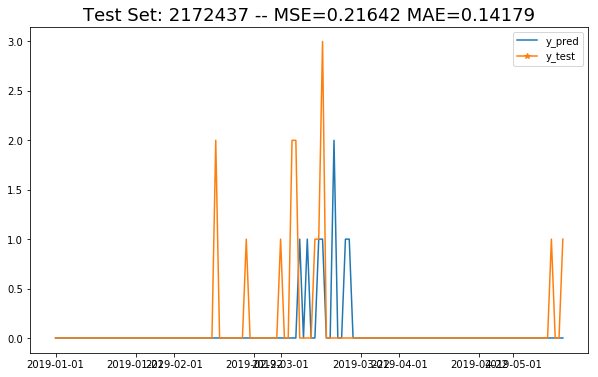

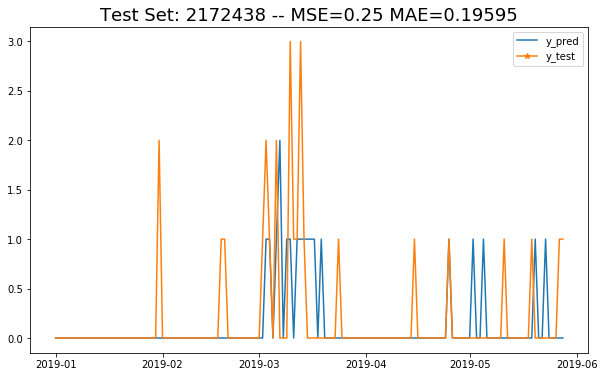

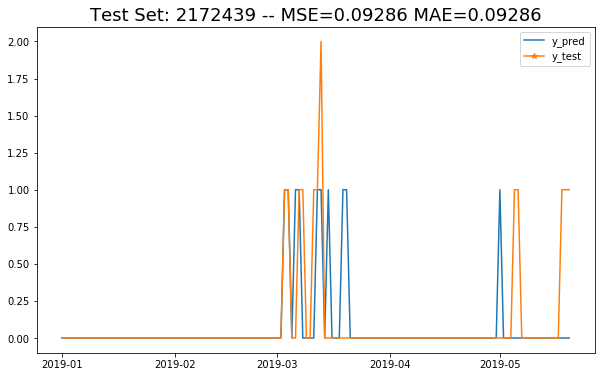

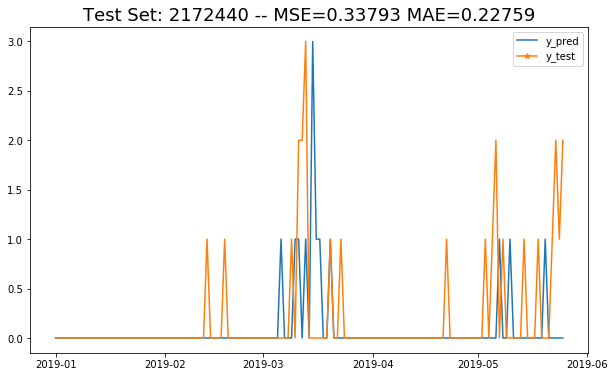

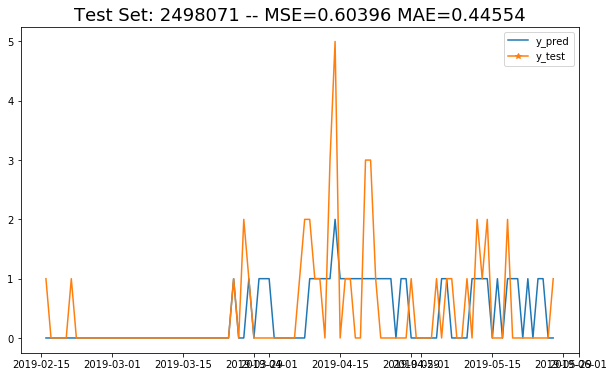

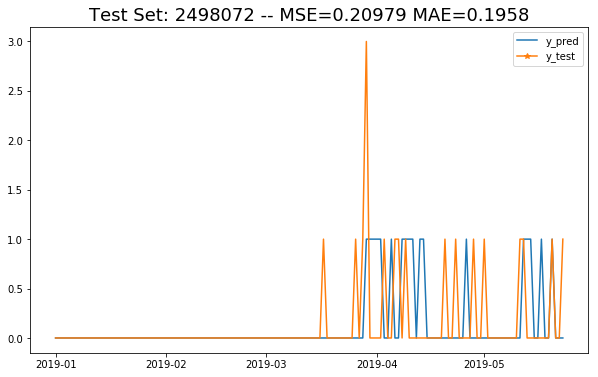

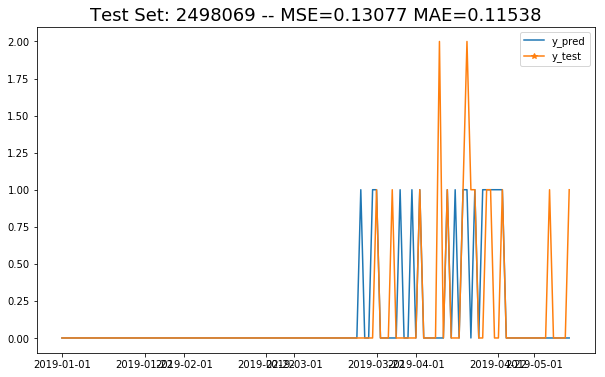

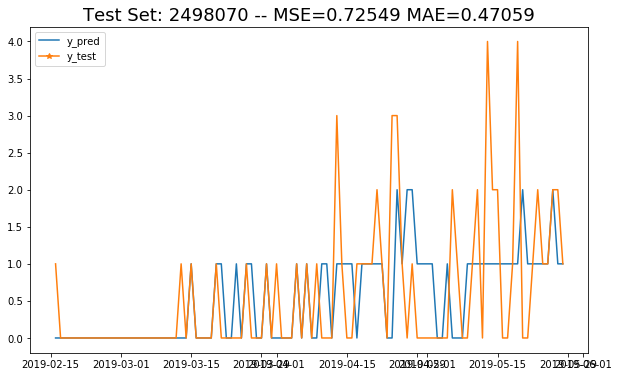

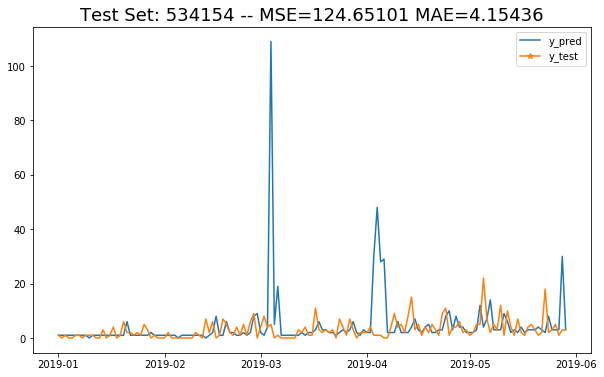

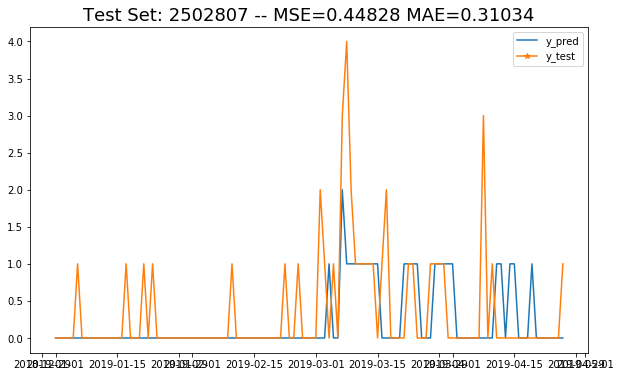

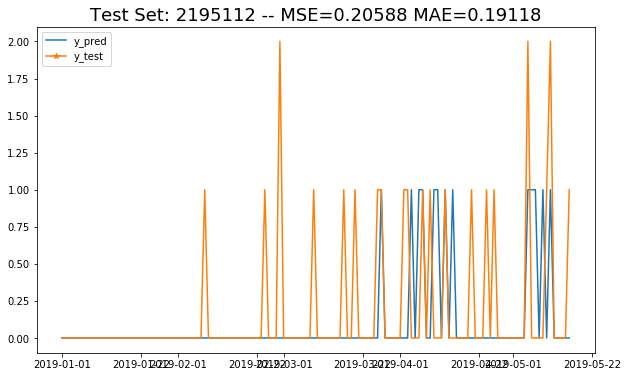

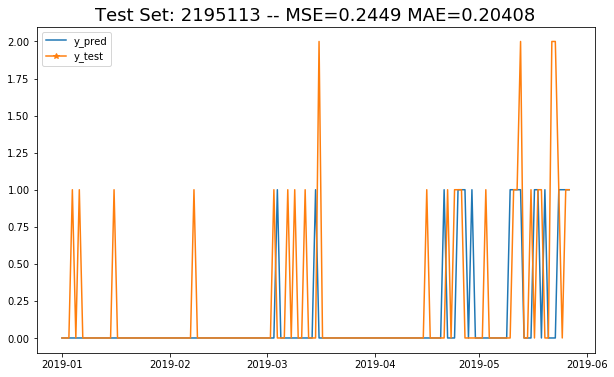

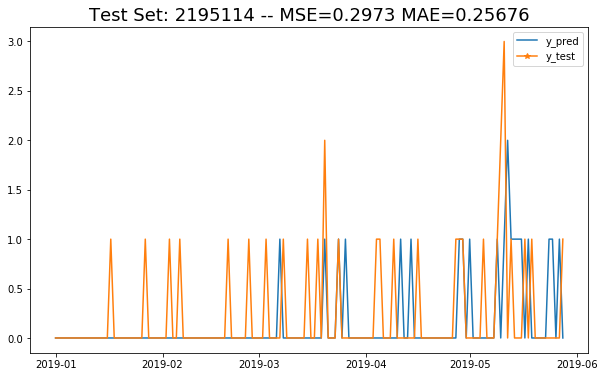

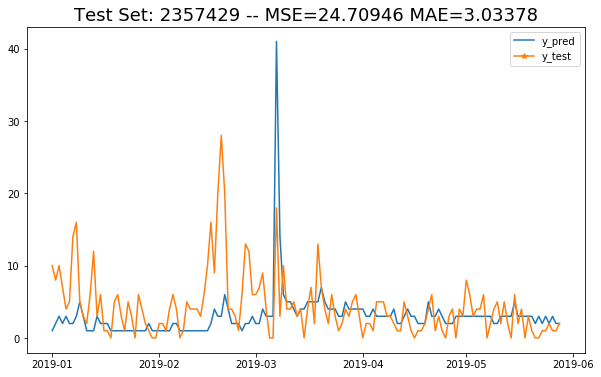

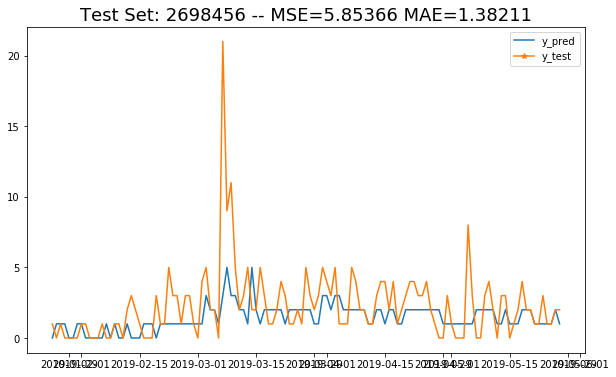

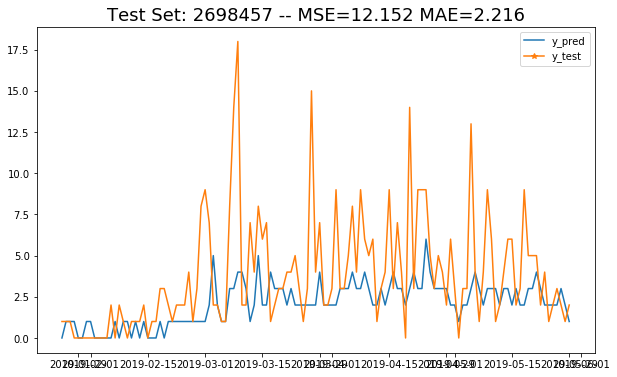

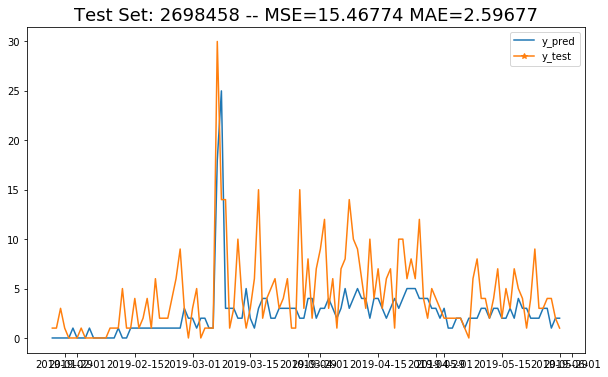

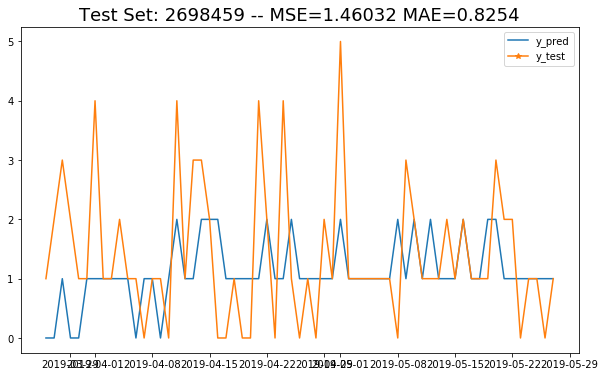

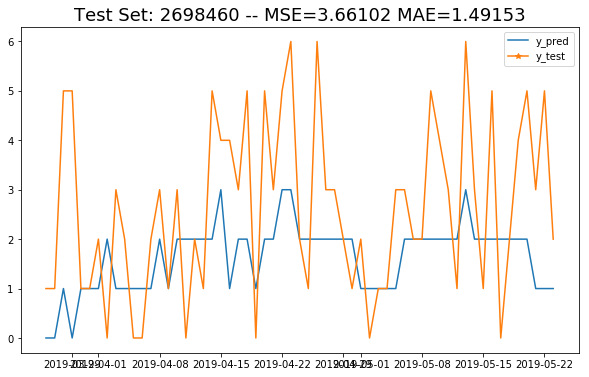

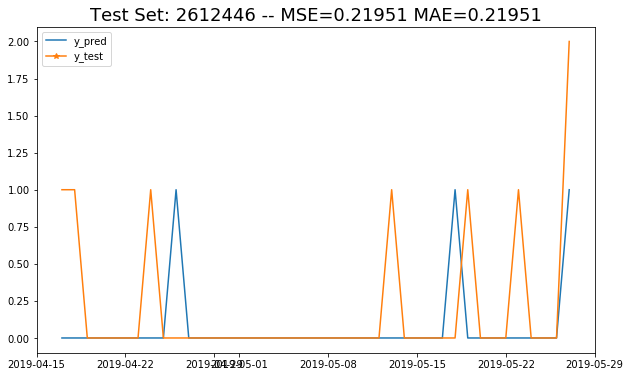

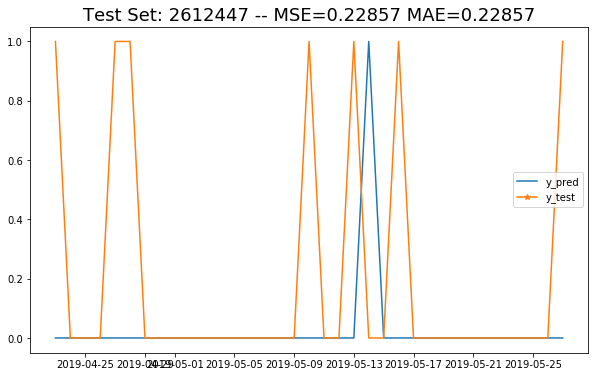

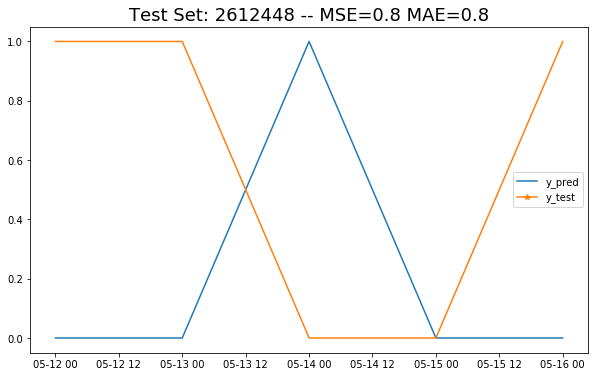

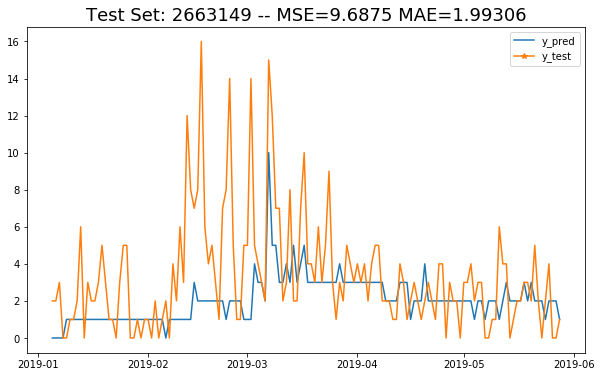

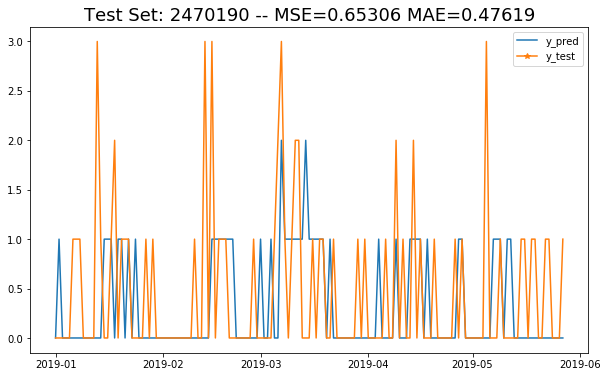

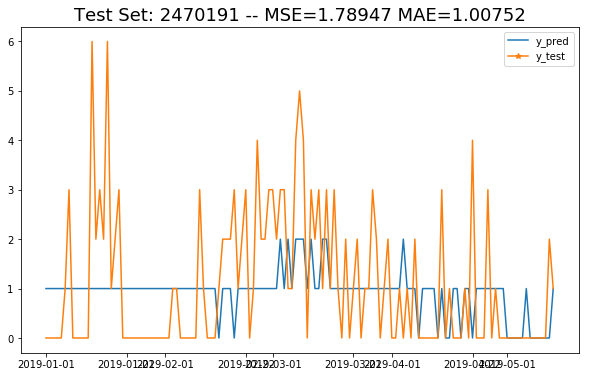

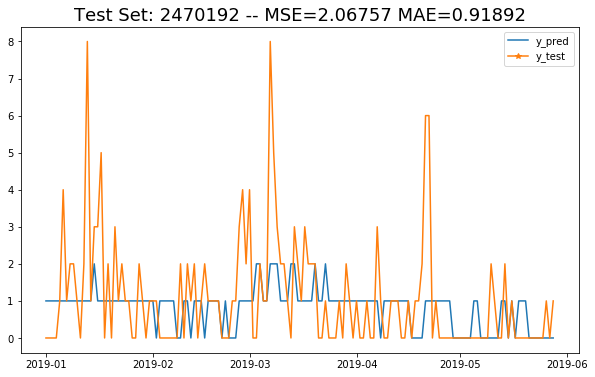

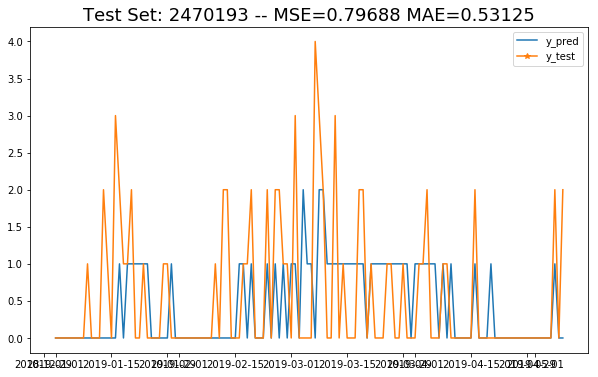

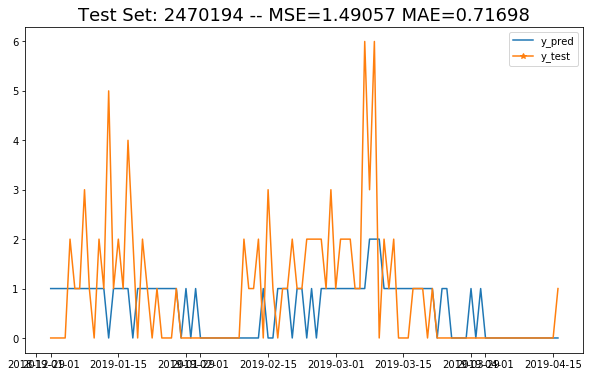

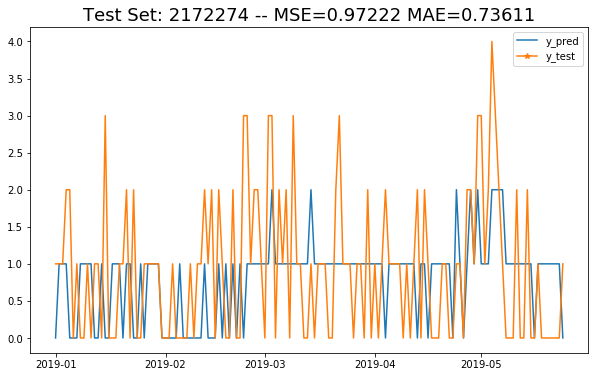

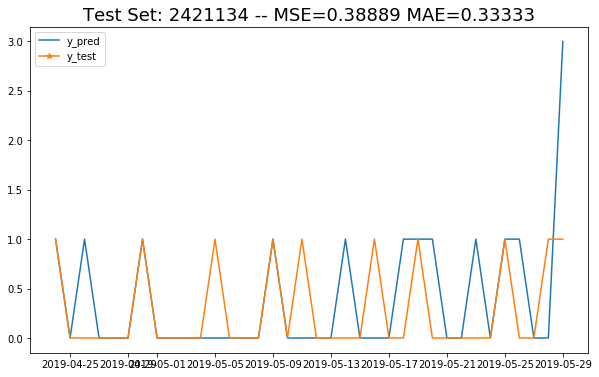

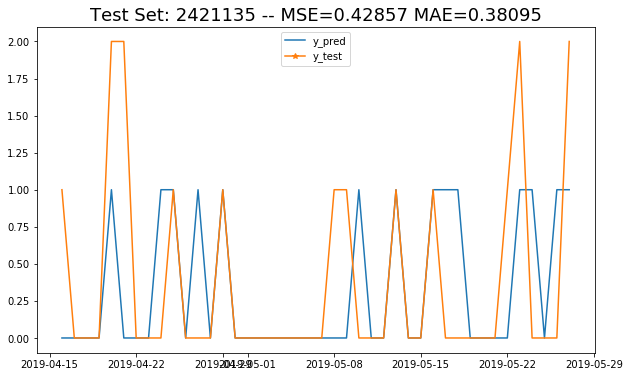

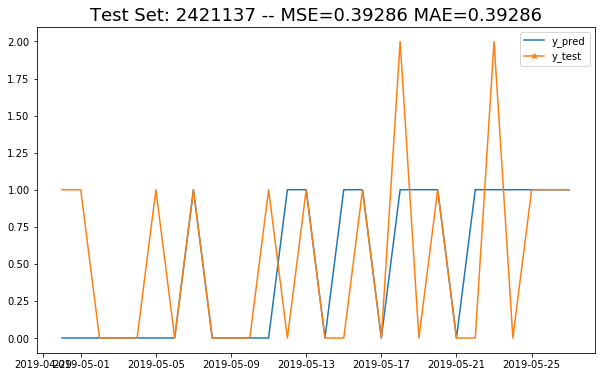

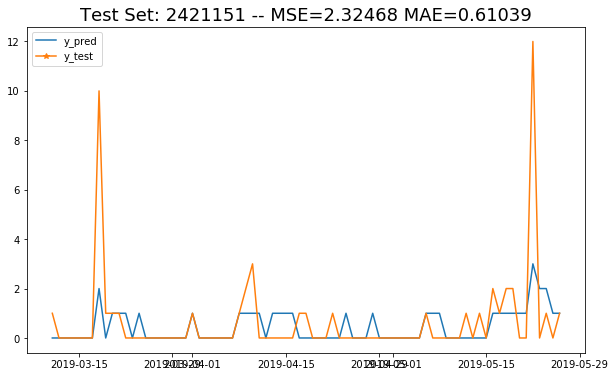

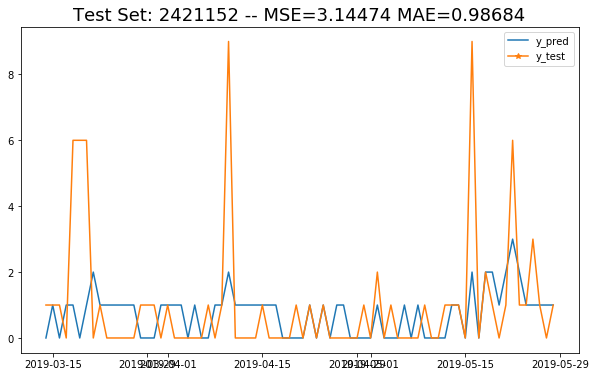

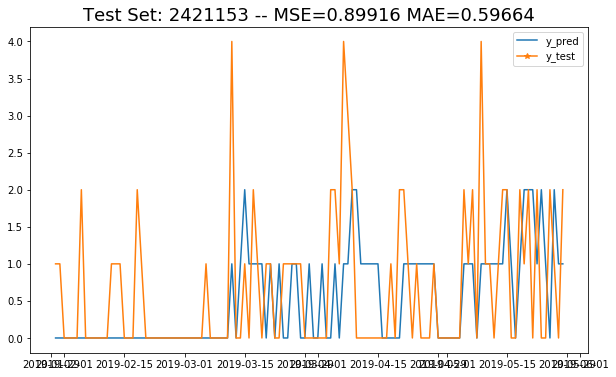

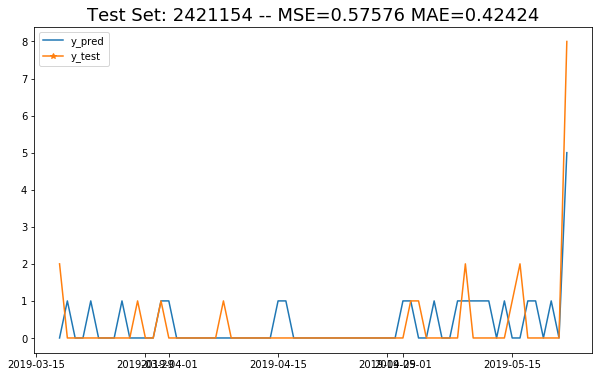

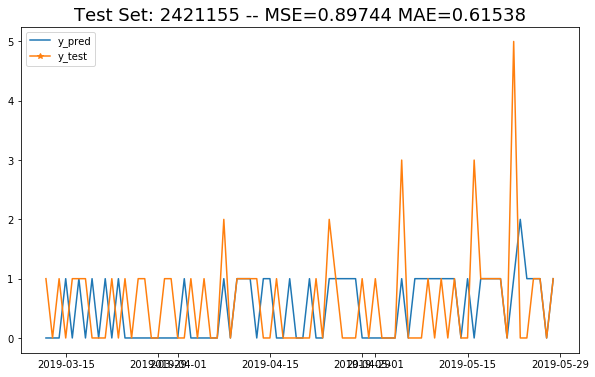

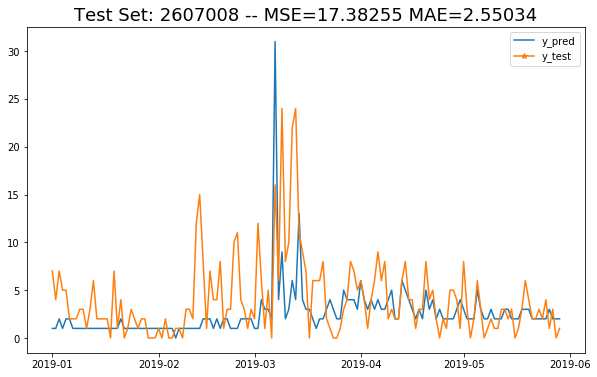

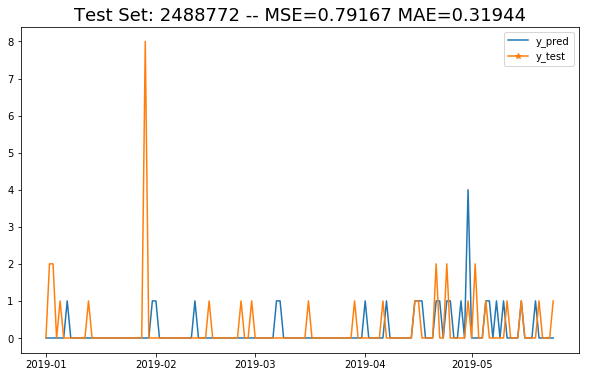

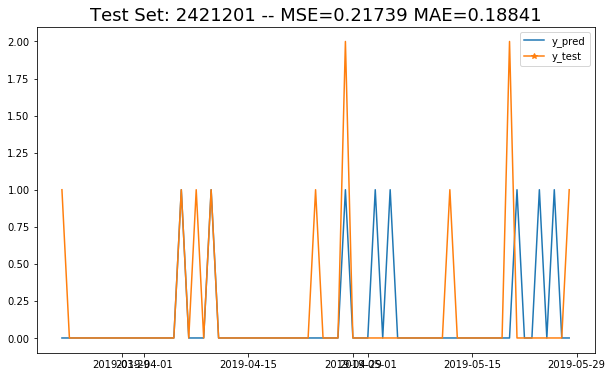

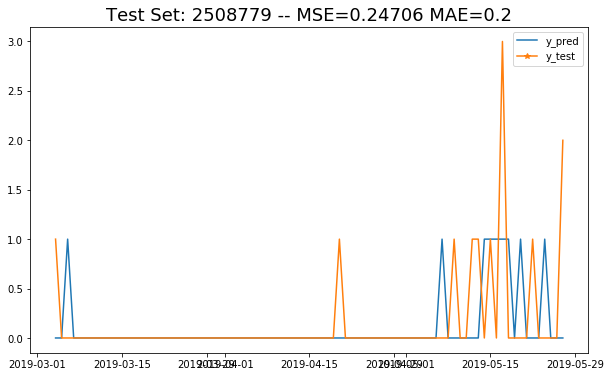

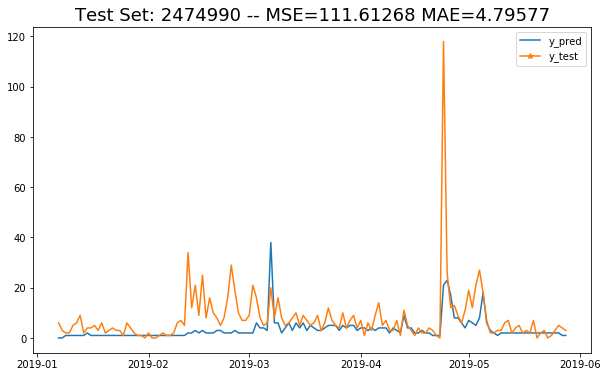

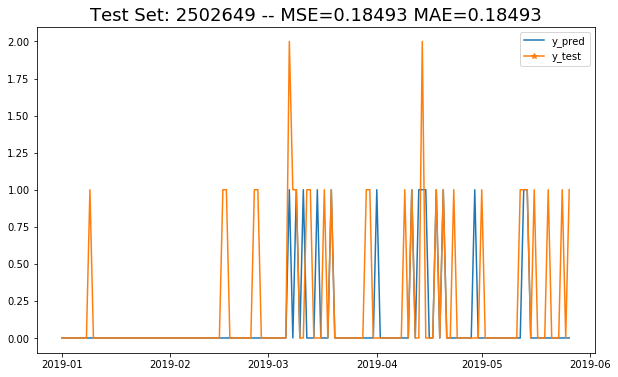

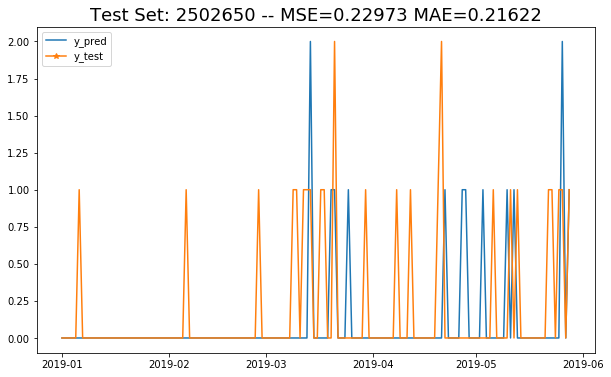

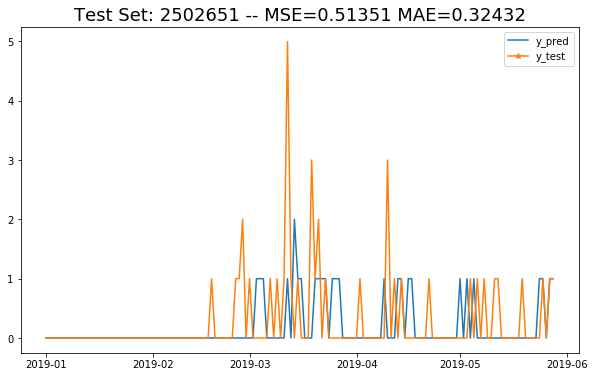

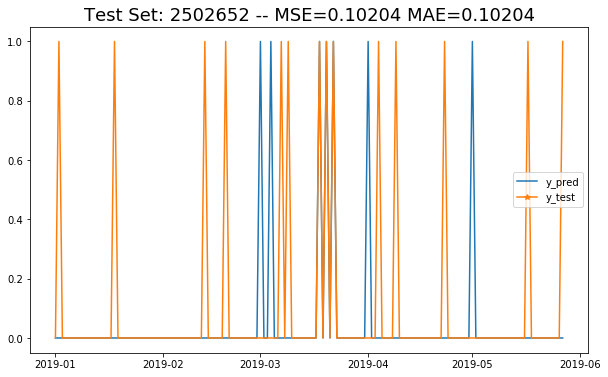

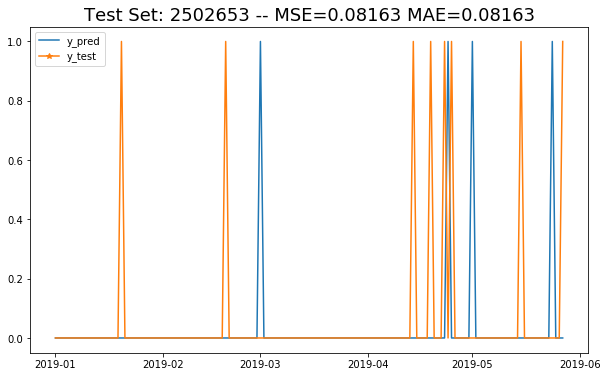

In [104]:
for sku in list(X_test['sku_id'].unique()):
    #sku = 2663149
    skures = results[results['sku_id']==sku].sort_values('paytime_day').reset_index()
    #print(skures.head())
    makerss = list(skures[skures['is_promo'] == 1].index.values) #促销的日子
    mse = np.round(np.sum(np.power((skures['y_test'] - skures['y_pred']),2))/len(skures['y_test']),5)
    mae = np.round(np.sum(np.abs((skures['y_test'] - skures['y_pred'])))/len(skures['y_test']),5)
    plt.figure(figsize=(10,6))
    plt.plot(skures['paytime_day'].apply(lambda x:datetime.datetime.strptime(x, "%Y-%m-%d")), skures['y_pred'])
    plt.plot(skures['paytime_day'].apply(lambda x:datetime.datetime.strptime(x, "%Y-%m-%d")), skures['y_test'],markevery=makerss, marker='*')
            #plt.plot(skures['paytime_day'].apply(lambda x:datetime.datetime.strptime(x, "%Y-%m-%d")), [np.mean(skures['y_test'])]*len(skures), linestyle=':', label='y_test mean')
    plt.title("Test Set: {} -- MSE={} MAE={}".format(sku,mse,mae),fontsize = 18)
    plt.legend()
    plt.show()

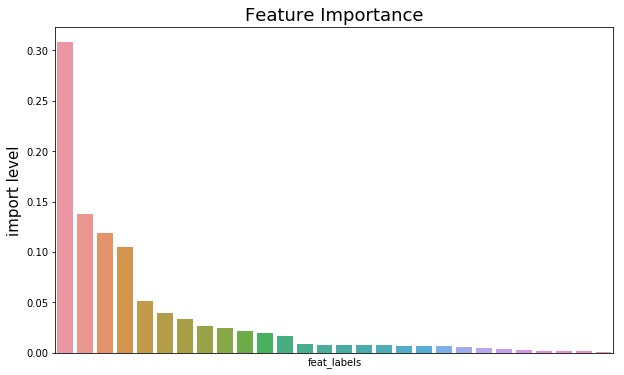

 1) logi_name_圆通速递                 0.307811
 2) qty_purchase_order             0.137411
 3) confirmed_qty                  0.119054
 4) shipped_qty                    0.104999
 5) target_qty_2db                 0.051847
 6) promo_flag_fnb                 0.039967
 7) sales_amount_1wb               0.033730
 8) tmall_id_43831555525.0         0.026516
 9) target_qty_26db                0.024966
10) account_goods_stock            0.021312
11) sales_amount_7db               0.019307
12) target_qty_9db                 0.016932
13) target_qty_21db                0.008768
14) promo_flag_2db                 0.008141
15) target_qty_20db                0.008047
16) tmall_id_38781831288.0         0.007923
17) target_qty_16db                0.007448
18) sales_amount_14db              0.006942
19) target_qty_14db                0.006700
20) target_qty_3db                 0.006550
21) target_qty_28db                0.006113
22) target_qty_4db                 0.004496
23) target_qty_6db              

In [109]:
# 随机森林分辨的特征重要性
# 特征重要程度
importances = gbr.feature_importances_
feat_labels = X_test.drop(['sku_id', 'paytime_day', 'target_qty'], axis=1).columns[sorted_index]
feat_impor = pd.DataFrame({'feat_labels':feat_labels,'importances':importances})
feat_impor = feat_impor[feat_impor['importances'] > 0.001]
feat_impor=feat_impor.sort_values('importances', ascending=False)

plt.figure(figsize=(10,6))
seaborn.barplot(x='feat_labels',y='importances',data=feat_impor)
plt.title("Feature Importance",fontsize = 18)
plt.ylabel("import level",fontsize = 15,rotation=90)
plt.xticks([])
plt.show()
for f in range(len(feat_impor)):
    print("%2d) %-*s %f" % (f + 1, 30, feat_impor['feat_labels'].iloc[f], feat_impor['importances'].iloc[f]))

results = pd.DataFrame({'y_test':y_test, 'y_pred':np.round(gbr.predict(X_t))})
results['paytime_day'] = X_test['paytime_day']
results['sku_id'] = X_test['sku_id']#[x[0] for x in y_test.index]
results.index = range(len(results))
results = results.merge(promotion, on='paytime_day')

for pl in list(set(results['promo_level_simple'])):
    a = results[results['promo_level_simple'] == pl]
    mae = np.round(np.sum(np.abs((a['y_test'] - a['y_pred'])))/len(a['y_test']),5)
    print('promo level: {}  MAE: {}  #sample: {}'.format(pl,mae,len(a)))
    
    


In [110]:
# 随机森林画图
MSEs = []
MAEs = []
SKUs = []
mindate = []
with PdfPages('predict_orderm_2.pdf') as pdf:
    for sku in list(set([x for x in results['sku_id']])):
        skures = results[results['sku_id']==sku].sort_values('paytime_day').reset_index()
        makerss = list(skures[skures['promo_level_simple'] != 'nan'].index.values)
        mse = np.round(np.sum(np.power((skures['y_test'] - skures['y_pred']),2))/len(skures['y_test']),5)
        mae = np.round(np.sum(np.abs((skures['y_test'] - skures['y_pred'])))/len(skures['y_test']),5)
        MAEs.append(mae)
        MSEs.append(mse)
        SKUs.append(sku)
        mindate.append(min(newdata_[newdata_['sku_id']==sku]['paytime_day']))         
        plt.figure(figsize=(10,6))
        plt.plot(skures['paytime_day'].apply(lambda x:datetime.datetime.strptime(x, "%Y-%m-%d")), skures['y_pred'], label='y_pred')
        plt.plot(skures['paytime_day'].apply(lambda x:datetime.datetime.strptime(x, "%Y-%m-%d")), skures['y_test'], label='y_test', markevery=makerss, marker='*')
        plt.title("Test Set: {} -- MSE={} MAE={}".format(sku,mse,mae),fontsize = 18)
        plt.legend()
        pdf.savefig()
        plt.close()
print('complete1')  
total_res = pd.DataFrame({'MSEs':MSEs,'MAEs':MAEs,'SKUs':SKUs, 'mindate':mindate})


with PdfPages('badcase_orderm_2.pdf') as pdf:
    for sku in list(set([x for x in results['sku_id']])):
        skures = results[results['sku_id']==sku].sort_values('paytime_day').reset_index()
        makerss = list(skures[skures['promo_level_simple'] != 'nan'].index.values)
        mse = np.round(np.sum(np.power((skures['y_test'] - skures['y_pred']),2))/len(skures['y_test']),5)
        mae = np.round(np.sum(np.abs((skures['y_test'] - skures['y_pred'])))/len(skures['y_test']),5)
        MAEs.append(mae)
        MSEs.append(mse)
        SKUs.append(sku)
        mindate.append(min(newdata_[newdata_['sku_id']==sku]['paytime_day']))
        if mae >= 1:            
            plt.figure(figsize=(10,6))
            plt.plot(skures['paytime_day'].apply(lambda x:datetime.datetime.strptime(x, "%Y-%m-%d")), skures['y_pred'], label='y_pred')
            plt.plot(skures['paytime_day'].apply(lambda x:datetime.datetime.strptime(x, "%Y-%m-%d")), skures['y_test'], label='y_test', markevery=makerss, marker='*')
            plt.title("Test Set: {} -- MSE={} MAE={}".format(sku,mse,mae),fontsize = 18)
            plt.legend()
            pdf.savefig()
            plt.close()
print('complete2')       

complete1
complete2


In [111]:
results.head(5)

,y_test,y_pred,paytime_day,sku_id,promo_level_simple,promo_name
0,0.0,0.0,2019-01-01,2172437,nan,NaN
1,0.0,0.0,2019-01-01,2172438,nan,NaN
2,0.0,0.0,2019-01-01,2172439,nan,NaN
3,0.0,0.0,2019-01-01,2172440,nan,NaN
4,0.0,0.0,2019-01-01,2498072,nan,NaN


In [112]:
# GBR拟合
alpha = 0.95 
gbr = GradientBoostingRegressor(n_estimators = 250, alpha=alpha, random_state = 0, max_depth=3, learning_rate=0.01) 
gbr.fit(X, y_train)

score = gbr.score(X,y_train) #R^2
print('Train set R^2: {}'.format(score))
print('Train set MSE: {}'.format((np.round(np.sum(np.power(y_train - gbr.predict(X),2))/len(y_train),5))))
print('Train set MAE: {}'.format((np.round(np.sum(np.abs(y_train - gbr.predict(X)))/len(y_train),5))))

y_upper = gbr.predict(X_t)
score = gbr.score(X_t,y_test)
print('Test set R^2: {}'.format(score))
print('Test set MSE: {}'.format((np.round(np.sum(np.power((y_test - y_upper),2))/len(y_test),5))))
print('Test set MAE: {}'.format((np.round(np.sum(np.abs((y_test - y_upper)))/len(y_test),5))))

Train set R^2: 0.7288046137940163
Train set MSE: 3.03666
Train set MAE: 0.79822
Test set R^2: 0.006025291682767553
Test set MSE: 9.26241
Test set MAE: 1.04886


In [113]:
gbr.set_params(alpha=1.0 - alpha)
gbr.fit(X, y_train)

score = gbr.score(X,y_train) #R^2
print('Train set R^2: {}'.format(score))
print('Train set MSE: {}'.format((np.round(np.sum(np.power(y_train - gbr.predict(X),2))/len(y_train),5))))
print('Train set MAE: {}'.format((np.round(np.sum(np.abs(y_train - gbr.predict(X)))/len(y_train),5))))

y_lower = gbr.predict(X_t)
score = gbr.score(X_t,y_test)
print('Test set R^2: {}'.format(score))
print('Test set MSE: {}'.format((np.round(np.sum(np.power((y_test - y_lower),2))/len(y_test),5))))
print('Test set MAE: {}'.format((np.round(np.sum(np.abs((y_test - y_lower)))/len(y_test),5))))

Train set R^2: 0.7288046137940163
Train set MSE: 3.03666
Train set MAE: 0.79822
Test set R^2: 0.006025291682767553
Test set MSE: 9.26241
Test set MAE: 1.04886


In [114]:
## case study 
sku =  2698460
skures = results[results['sku_id']==sku].sort_values('paytime_day').reset_index()

In [115]:
results.info()
results.promo_name.unique()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5259 entries, 0 to 5258
Data columns (total 6 columns):
y_test                5259 non-null float64
y_pred                5259 non-null float64
paytime_day           5259 non-null object
sku_id                5259 non-null int64
promo_level_simple    5259 non-null object
promo_name            1323 non-null object
dtypes: float64(2), int64(1), object(3)
memory usage: 287.6+ KB


array([nan, '年货节 300-10,500-30', '年三十', '初一', '初二', '初三', '初四', '初五',
       '初六', '初柒', '健身器械品类日', '开新季', '女王节200-10,300-20,500-30', '跑步节',
       '新风尚', '出游季', '亲子节', '55聚划算大促', '520'], dtype=object)

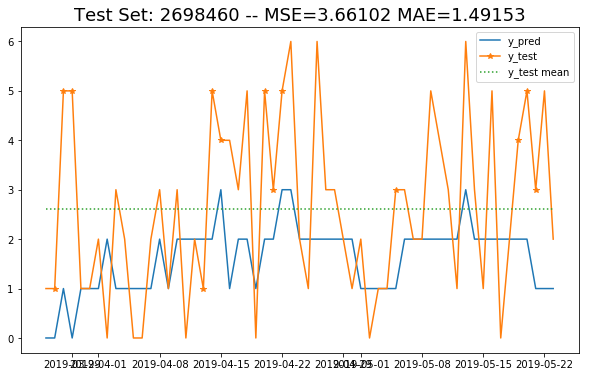

In [116]:
makerss = list(skures[skures['promo_level_simple'] != 'nan'].index.values) #促销的日子
mse = np.round(np.sum(np.power((skures['y_test'] - skures['y_pred']),2))/len(skures['y_test']),5)
mae = np.round(np.sum(np.abs((skures['y_test'] - skures['y_pred'])))/len(skures['y_test']),5)
plt.figure(figsize=(10,6))
plt.plot(skures['paytime_day'].apply(lambda x:datetime.datetime.strptime(x, "%Y-%m-%d")), skures['y_pred'], label='y_pred')
plt.plot(skures['paytime_day'].apply(lambda x:datetime.datetime.strptime(x, "%Y-%m-%d")), skures['y_test'], markevery=makerss, marker='*', label='y_test')
plt.plot(skures['paytime_day'].apply(lambda x:datetime.datetime.strptime(x, "%Y-%m-%d")), [np.mean(skures['y_test'])]*len(skures), linestyle=':', label='y_test mean')
plt.title("Test Set: {} -- MSE={} MAE={}".format(sku,mse,mae),fontsize = 18)
plt.legend()
plt.show()

In [1]:
product[product['family_id']==695]

NameError: name 'product' is not defined